In [24]:
import optuna as opt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
#from twilio.rest import Client
import pickle

import time

import sys
import os 


sys.path.append('../../pscapes')
sys.path.append('../../nk-ml-2024/')


from torch.utils.data import DataLoader

from pscapes.landscape_class import ProteinLandscape
from pscapes.utils import dict_to_np_array, np_array_to_dict

from src.architectures import SequenceRegressionCNN, SequenceRegressionLinear, SequenceRegressionMLP, SequenceRegressionLSTM, SequenceRegressionTransformer

from src.ml_utils import train_val_test_split_ohe, landscapes_ohe_to_numpy

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 

from src.train_utils import train_models_from_hparams_NK, read_MLP_hparams, read_CNN_hparams, read_LSTM_hparams, read_transformer_hparams

from src.analysis import get_latent_representation, instantiate_model_from_study

from sklearn.neighbors import kneighbors_graph
import math
import networkx as nx
from scipy.sparse import diags

In [25]:
from src.analysis import instantiate_model_from_study

In [44]:
import matplotlib.pyplot as plt

In [26]:
HPARAM_PATH = '../hyperopt/results/NK_hyperopt_results.pkl'
DATA_PATH = '../data/nk_landscapes/'
MODEL_SAVEPATH = '../models/'
RESULT_PATH = '../results/'
SEQ_LEN = 6
AA_ALPHABET  = 'ACDEFG'
N_REPLICATES = 1

In [27]:
with open(HPARAM_PATH, 'rb') as handle: 
    NK_hparams = pickle.load(handle)

In [23]:
#load landscape data 
landscapes = []
print('Loading landscapes.')
for k in range(SEQ_LEN):
    replicate_list = []
    for r in range(N_REPLICATES):
        landscape = ProteinLandscape(csv_path=DATA_PATH+'/k{0}_r{1}.csv'.format(k,r), amino_acids=AA_ALPHABET)
        replicate_list.append(landscape)
    landscapes.append(replicate_list)
landscapes = [[i.fit_OHE() for i in j] for j in landscapes]

print('Calculating train-test-val splits')
splits = [train_val_test_split_ohe(i, random_state=1) for i in landscapes]
#landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_index] 

Loading landscapes.
Calculating train-test-val splits


In [42]:
model_names = ['linear', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer', 'RF', 'GB']


In [13]:
mlp_models = [[instantiate_model_from_study('mlp', i)] for i in NK_hparams['mlp']]
cnn_models = [[instantiate_model_from_study('cnn', i)] for i in NK_hparams['cnn']] 
ulstm_models = [[instantiate_model_from_study('ulstm', i)] for i in NK_hparams['ulstm']] 


In [54]:
NK_hparams['transformer'][2].trials_dataframe()

""


ValueError: No trials are completed yet.

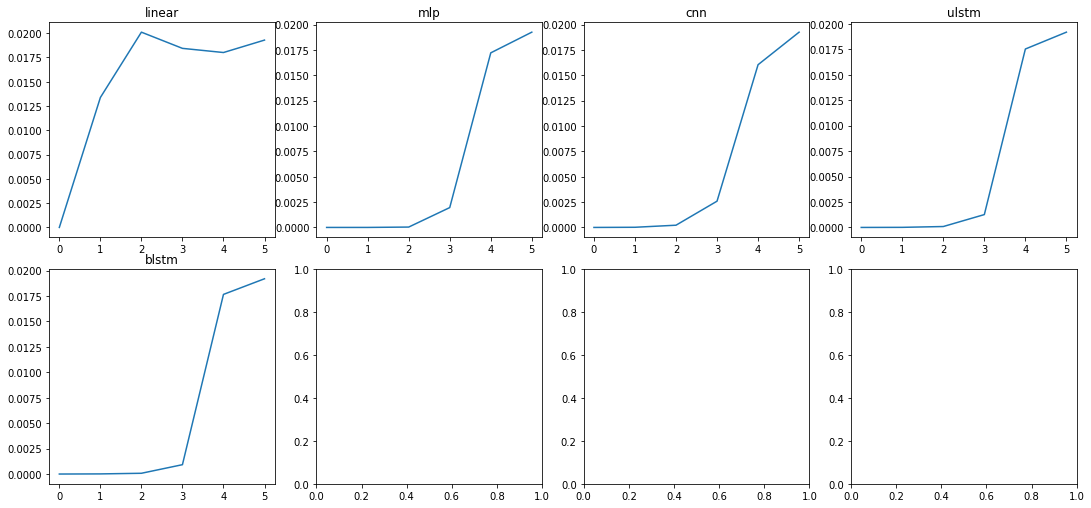

In [45]:
fig,ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
fig.tight_layout()
for index, axis in enumerate(ax.ravel()):
    model_val_losses = [NK_hparams[model_names[index]][k_val].best_value for k_val in range(SEQ_LEN)]
    axis.plot(model_val_losses)
    #axis.set_ylim(-1.5,1.5)
    axis.set_title(model_names[index])
    
ax[0,0].set_ylabel('Validation Loss (MSE)')
ax[1,0].set_xlabel('$K$ value')

ax[1,0].set_ylabel('Validation Loss (MSE)')

In [32]:
[[mlp_models[k_val][replicate].load_state_dict(torch.load(MODEL_SAVEPATH+'{}_NK_k{}_r{}.pt'.format('mlp', k_val, replicate), weights_only=True)) 
  for replicate in range(N_REPLICATES)] for k_val in range(SEQ_LEN)] #load weights
[[cnn_models[k_val][replicate].load_state_dict(torch.load(MODEL_SAVEPATH+'{}_NK_k{}_r{}.pt'.format('cnn', k_val, replicate), weights_only=True)) 
  for replicate in range(N_REPLICATES)] for k_val in range(SEQ_LEN)]

[[<All keys matched successfully>],
 [<All keys matched successfully>],
 [<All keys matched successfully>],
 [<All keys matched successfully>],
 [<All keys matched successfully>],
 [<All keys matched successfully>]]

In [33]:
landscapes_as_tensor = [[torch.from_numpy(i).to(torch.float32) for i in j[0]] for j in splits]
flattened_landscapes = [[i.reshape(i.shape[0], i.shape[1]*i.shape[2]) for i in j[0]] for j in splits]

In [34]:
degree=30

In [35]:
mlp_latent_reps = [get_latent_representation(mlp_models[i][0],'mlp', landscapes_as_tensor[i][0]) for i in range(len(mlp_models))]
cnn_latent_reps = [get_latent_representation(cnn_models[i][0],'cnn', landscapes_as_tensor[i][0]) for i in range(len(mlp_models))]

In [37]:
cnn_latent_reps[0].shape

torch.Size([46656, 192, 1])